In [2]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import GPy

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import preprocessing
from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
df = pd.read_csv('../../../Data/NAPOLI/dataVehicle1.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

      TIME    LEAD_POS  FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0        1     9.45102     2.38000   4.39751     4.21765         3.73
1        2     9.89652     2.80989   4.51239     4.38015         3.73
2        3    10.35270     3.25411   4.61132     4.50423         3.73
3        4    10.81753     3.70859   4.68523     4.58534         3.73
4        5    11.28818     4.16912   4.72783     4.62536         3.73
...    ...         ...         ...       ...         ...          ...
1884  1885  1370.01124  1351.63571  14.01855    14.21913         3.73
1885  1886  1371.41119  1353.05787  13.98043    14.22416         3.73
1886  1887  1372.80736  1354.48035  13.94293    14.22541         3.73
1887  1888  1374.19992  1355.90270  13.90839    14.22166         3.73
1888  1889  1375.58930  1357.32449  13.87907    14.21401         3.73

[1889 rows x 6 columns]


In [4]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

t = np.linspace(0, 188.8, 1888, endpoint=False) # 288.4 for JIANG # 188.8 for NAPOLI
#t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)

1889
0


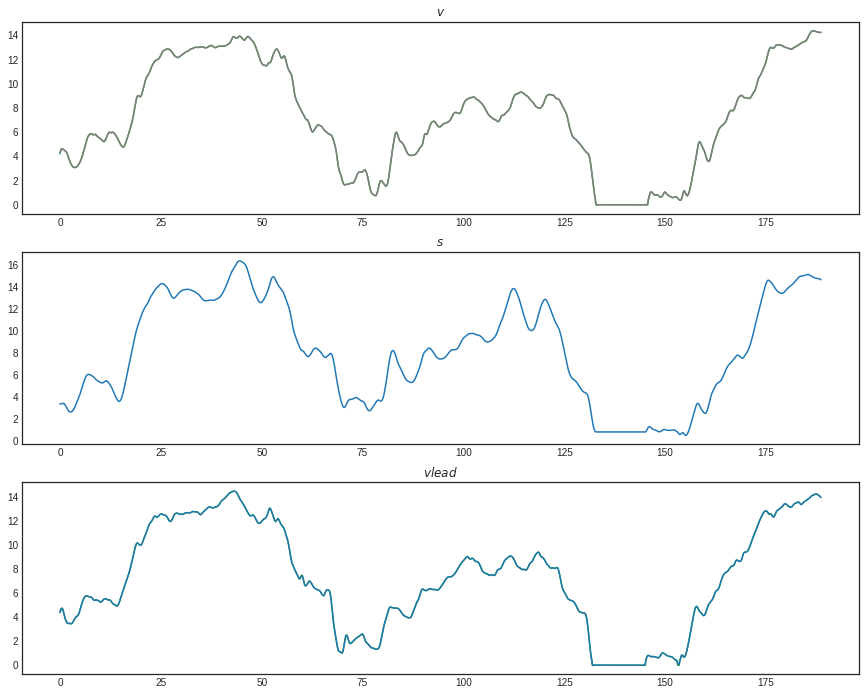

In [5]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

FD_v = FD(followPos[statTraj:endsTraj],t[statTraj:endsTraj])
FD_vlead = FD(leadPos[statTraj:endsTraj],t[statTraj:endsTraj])

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v[statTraj:endsTraj], 'tab:green')
ax1.plot(t[statTraj:endsTraj], FD_v.reshape(followPos[statTraj:endsTraj].shape[0],)[:], 'tab:gray')
ax1.set_title('$v$')
#ax2.plot(t[statTraj:endsTraj], followPos[statTraj:endsTraj], 'tab:green')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj])
#ax2.plot(t[statTraj:endsTraj], leadPos[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.plot(t[statTraj:endsTraj], FD_vlead.reshape(leadPos[statTraj:endsTraj].shape[0],)[:])
ax3.set_title('$vlead$')

plt.show()

# GPy

In [25]:
#st_Traj = 0
#en_Traj = 2308

# Training (UnStandardized)

#X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

#Y_train = v_p[st_Traj:en_Traj].reshape(-1,1)  # RMSE(A)
#Y_train = v[st_Traj+1:en_Traj+1].reshape(-1,1)  # RMSE(V)
#Y_train = s[st_Traj+1:en_Traj+1].reshape(-1,1) # RMSE(S)

# Testing (UnStandardized)

#Y_test = v_p[en_Traj+1:].reshape(-1,1) # RMSE(A)
#Y_test = v[en_Traj+1:].reshape(-1,1)   # RMSE(V)
#Y_test = s[en_Traj+1:].reshape(-1,1)    # RMSE(S)

#X_prior = np.stack((v,s,vlead,t), axis=1) # Prior

In [6]:
st_Traj = 0
en_Traj = 1551 #1551 # 2307 # 9405

# Training (Standardized)
v_mean = v[st_Traj:en_Traj].mean()
v_stdev = v[st_Traj:en_Traj].std()

s_mean = s[st_Traj:en_Traj].mean()
s_stdev = s[st_Traj:en_Traj].std()

vlead_mean = vlead[st_Traj:en_Traj].mean()
vlead_stdev = vlead[st_Traj:en_Traj].std()

v_p_mean = v_p[st_Traj:en_Traj].mean()
v_p_stdev = v_p[st_Traj:en_Traj].std()  

X_train = np.stack(((v[st_Traj:en_Traj]-v_mean)/v_stdev,(s[st_Traj:en_Traj]-s_mean)/s_stdev,(vlead[st_Traj:en_Traj]-vlead_mean)/vlead_stdev,t[st_Traj:en_Traj]), axis=1)

Y_train = ((v_p[st_Traj+1:en_Traj+1]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_train = ((v[st_Traj+1:en_Traj+1]-v_mean)/v_stdev).reshape(-1,1)  # RMSE(V)
#Y_train = ((s[st_Traj+1:en_Traj+1]-s_mean)/s_stdev).reshape(-1,1) # RMSE(S)

# Testing (Standardized)

Y_test = ((v_p[en_Traj+1:]-v_p_mean)/v_p_stdev).reshape(-1,1)  # RMSE(A)
#Y_test = ((v[en_Traj+1:]-v_mean)/v_stdev).reshape(-1,1)       # RMSE(V)
#Y_test = ((s[en_Traj+1:]-s_mean)/s_stdev).reshape(-1,1)       # RMSE(S)

X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [8]:
noise = 0.017

#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)

#myKernel = k1*k2
myKernel = GPy.kern.Exponential(input_dim=3)
gpr = GPy.models.GPRegression(X_train[:,:3], Y_train, kernel=myKernel)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize()

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
Exponential.variance,12.259662347531613,+ve,
Exponential.lengthscale,5342.789367794902,+ve,
Gaussian_noise.variance,0.00028900000000000003,+ve fixed,


In [9]:
# Obtain optimized kernel parameters
#l = gpr.mlp.weight_variance.values[0]
#sigma_f = np.sqrt(gpr.mlp.variance.values[0])
#print(l, sigma_f)

# Plot the results with the built-in plot function
mu_s, cov_s = gpr.predict(X_prior[:,:3])
#np.save('ResearchUpdate#43/GPModels/ASTAZERO/GP_Exp_Stand_ASTA(S).npy', gpr.param_array)

In [183]:
#np.savetxt("gp_pred_data.csv", mu_s, delimiter=",")

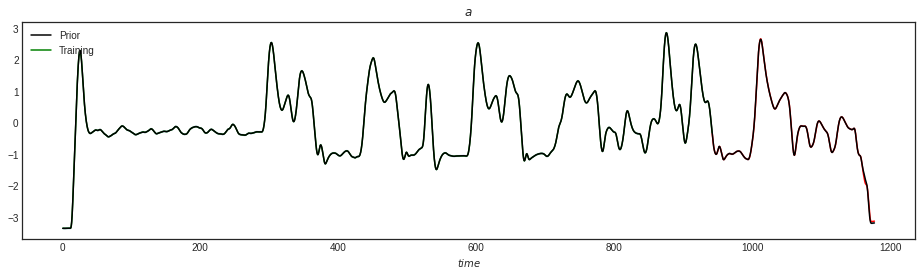

In [10]:
mu = mu_s.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

ax.fill_between(X_prior[:,3], mu + uncertainty, mu - uncertainty, alpha=0.3)
p1, = ax.plot(X_train[:,3], Y_train, 'g')
ax.plot(t[en_Traj+1:], Y_test, 'r')
g1, = ax.plot(X_prior[:,3], mu, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Prior', 'Training'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

# RMSE(A)

In [7]:
# Model creation, without initialization:
#k1 = GPy.kern.ExpQuad(input_dim=3)
#k2 = GPy.kern.Exponential(input_dim=3)
myKernel = GPy.kern.Exponential(input_dim=3)
#myKernel = k1+k2
load_gpr = GPy.models.GPRegression(X_train[:,:3], Y_train[:,0].reshape(-1,1), kernel=myKernel, initialize=False)
load_gpr.update_model(False) # do not call the underlying expensive algebra on load
load_gpr.initialize_parameter() # Initialize the parameters (connect the parameters up)
load_gpr[:] = np.load('../GPModels/NAPOLI/GP_Exp_Stand_NAPOLI(A).npy') # Load the parameters
load_gpr.update_model(True) # Call the algebra only once
print(load_gpr)


Name : GP regression
Objective : 3998.4472225793734
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  Exponential.variance     |       48.22202481716642  |      +ve      |        
  Exponential.lengthscale  |       35.45634252844315  |      +ve      |        
  Gaussian_noise.variance  |  0.00028900000000000003  |      +ve      |        


In [8]:
X_prior = np.stack(((v-v_mean)/v_stdev,(s-s_mean)/s_stdev,(vlead-vlead_mean)/vlead_stdev,t), axis=1) # Prior

In [9]:
mu_s = np.zeros(X_prior.shape[0])
cov_s = np.zeros((X_prior.shape[0], X_prior.shape[0]))
gp_v = np.zeros(X_prior.shape[0])
gp_pos = np.zeros(X_prior.shape[0])
gp_s = np.zeros(X_prior.shape[0])

mu_s[0] =  v_p[0]
gp_pos[0] = followPos[0]
gp_v[0] = v[0]
gp_s[0] = s[0]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        mu_s[k+1], cov_s[k+1,:] = load_gpr.predict(X_prior[k,:3].reshape(1,-1))
        unstand_acc = mu_s[k+1]*v_p_stdev+v_p_mean
        gp_v[k+1] = gp_v[k]+(unstand_acc)*(dt)
        X_prior[k+1,0] = (gp_v[k+1]-v_mean) / v_stdev
        gp_pos[k+1] = gp_pos[k] + (gp_v[k+1] + gp_v[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        gp_s[k+1] = leadPos[k+1] - gp_pos[k+1] - leadLen[0]
        X_prior[k+1,1] = (gp_s[k+1]-s_mean) / s_stdev

In [12]:
# saving data in csv files 
uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
allData = np.stack((mu_s, uncertainty, gp_v, gp_s, v_p, v, s), axis=1)
np.savetxt('../../../Results/GP/Predictions/NAPOLI/GP_Exp_Stand_NAPOLI(A).csv', allData, delimiter=',')

In [15]:
# loading predictions from csv files
my_data = genfromtxt('../../../Results/GP/Predictions/NAPOLI/GP_Exp_Stand_NAPOLI(A).csv', delimiter=',')
mu_s = my_data[:,0]
uncertainty = my_data[:,1]
gp_v = my_data[:,2]
gp_s = my_data[:,3]
v_p = my_data[:,4]
v = my_data[:,5]
s = my_data[:,6]

GP Acc. RMSE: 0.4517737077500583
GP Vel. RMSE 0.30533842249414933
GP Head. RMSE 1.0160196229433118
GP Acc. RMSE: 0.7815669963185315
GP Vel. RMSE 0.6656875982727389
GP Head. RMSE 2.972311580402477


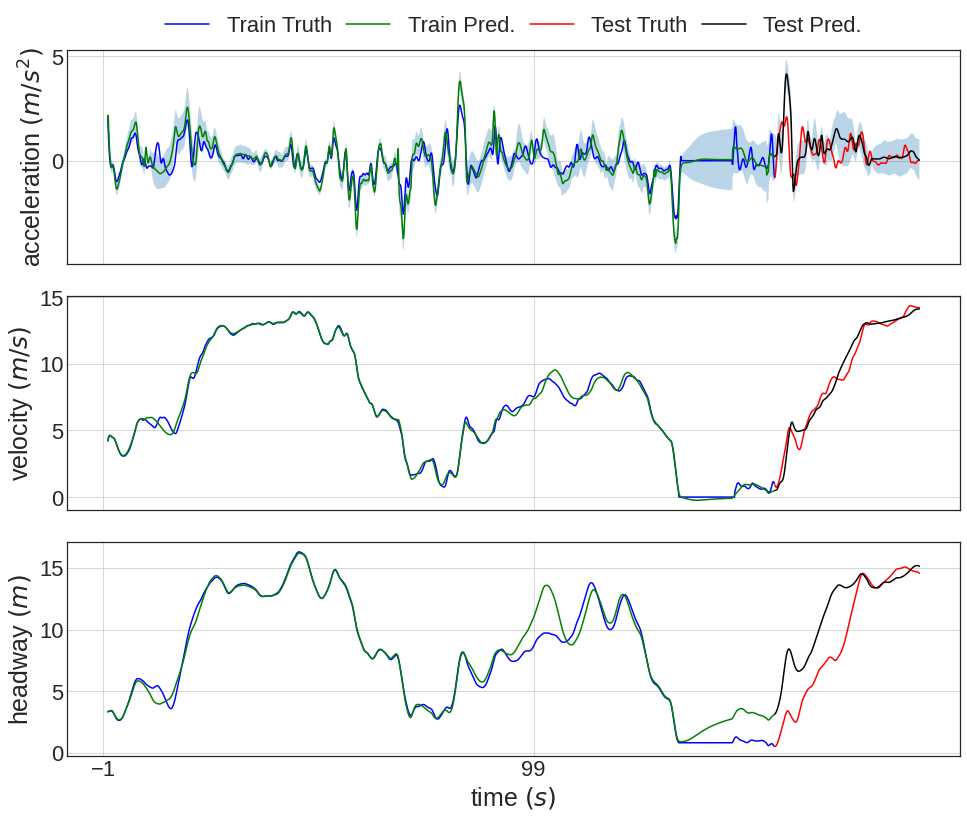

In [16]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(mu_s[:en_Traj], v_p[:en_Traj])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gp_v[:en_Traj], v[:en_Traj])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gp_s[:en_Traj], s[:en_Traj])))

print('GP Acc. RMSE:', np.sqrt(mean_squared_error(mu_s[en_Traj:], v_p[en_Traj:])))
print("GP Vel. RMSE", np.sqrt(mean_squared_error(gp_v[en_Traj:], v[en_Traj:])))
print("GP Head. RMSE", np.sqrt(mean_squared_error(gp_s[en_Traj:], s[en_Traj:])))

fig = plt.figure() 

gs = fig.add_gridspec(3, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

mu = mu_s.ravel()
#uncertainty = 1.96 * np.sqrt(np.diag(cov_s))

ax[0].fill_between(X_prior[:,3], mu + uncertainty, mu - uncertainty, alpha=0.3)
b1, = ax[0].plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax[0].plot(X_prior[:en_Traj,3], mu_s[:en_Traj], "g")
r1, = ax[0].plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax[0].plot(X_prior[en_Traj:,3], mu_s[en_Traj:], "k")
ax[0].set_ylabel('acceleration $(m/s^2)$')
ax[0].grid(True)
ax[0].xaxis.set_ticks(np.arange(min(t), max(t), 100)-1)

ax[1].plot(X_train[:,3], v[:en_Traj], "b")
ax[1].plot(X_prior[:en_Traj,3], gp_v[:en_Traj], "g")
ax[1].plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax[1].plot(X_prior[en_Traj:,3], gp_v[en_Traj:], "k")
ax[1].set_ylabel('velocity $(m/s)$')
ax[1].grid(True)

ax[2].plot(X_train[:,3], s[:en_Traj], "b")
ax[2].plot(X_prior[:en_Traj,3], gp_s[:en_Traj], "g")
ax[2].plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax[2].plot(X_prior[en_Traj:,3], gp_s[en_Traj:], "k")
ax[2].set_ylabel('headway $(m)$')
ax[2].grid(True)
ax[2].set_xlabel('time $(s)$')

ax[0].legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test Truth', 'Test Pred.'), bbox_to_anchor=(0.1,1.02,0.8,0.2), mode='expand', loc='lower left', ncol=4, borderaxespad=0, shadow=False)

#plt.savefig('../../../Results/GP/Plots/NAPOLI/GP_Exp_Stand_NAPOLI(A).png')
plt.show()